In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import ViTForImageClassification, ViTFeatureExtractor
from PIL import Image
import pandas as pd
import os

In [5]:
from transformers import ViTForImageClassification, ViTFeatureExtractor

#Load ImageNet pre-trained ViT
model_name = 'google/vit-base-patch16-224-in21k' #Model version

model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels = 4,
    problem_type="multi_label_classification"
) 

# Feature extractor for preprocessing images
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


# DATASET.

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/covid19-radiography-database


In [13]:
#Read dataset.
data_path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID"

# List files inside the original dataset
files = os.listdir(data_path)
print("Files in dataset:", files)  # Show first 10 files


Files in dataset: ['images', 'masks']


Image 1 shape: (299, 299, 3)
Image 2 shape: (299, 299, 3)
Image 3 shape: (299, 299, 3)
Image 4 shape: (299, 299, 3)
Image 5 shape: (299, 299, 3)


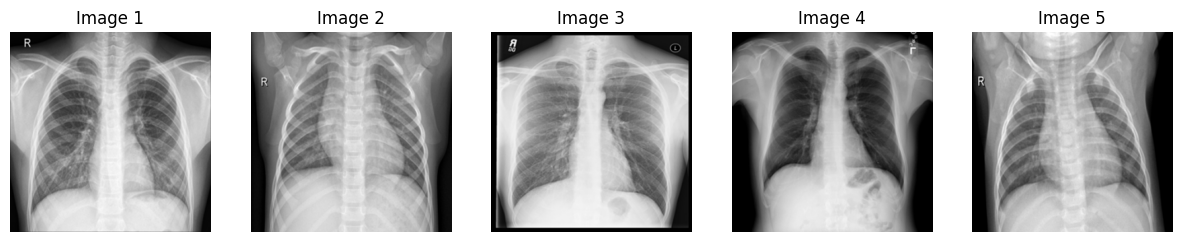

In [22]:
import matplotlib.pyplot as plt
import cv2

# Updated path to the correct folder
dataset_path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images"

# Get all image file paths
image_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path)]

# Select 5 images
num_images = min(5, len(image_files))  # Ensure we don't exceed available images
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i, img_path in enumerate(image_files[:num_images]):
    img = cv2.imread(img_path)
    print(f"Image {i+1} shape: {img.shape}")  # Print shape
    img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)  # Convert to RGB

    # Show image
    axes[i].imshow(img)
    axes[i].set_title(f"Image {i+1}")  # Title as Image number
    axes[i].axis("off")

plt.show()

In [ ]:
processed_dataset_path = "/kaggle/working/Dataset_Processed"

# Process each split
for split in ["train", "test", "validation"]:
    split_path = os.path.join(dataset_path, split)
    new_split_path = os.path.join(processed_dataset_path, split)
    os.makedirs(new_split_path, exist_ok=True)

    # Process images
    for class_name in os.listdir(split_path):
        class_dir = os.path.join(split_path, class_name)
        new_class_dir = os.path.join(new_split_path, class_name)
        os.makedirs(new_class_dir, exist_ok=True)

        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            new_img_path = os.path.join(new_class_dir, img_name)

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
            cv2.imwrite(new_img_path, img)  # Save

print("Grayscale conversion complete!")

# TRAIN.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = torch.nn.BCEWithLogitsLoss()  # for multi-label classification

epochs = 1  # adjust as needed

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in dataloader:
        inputs = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(pixel_values=inputs)
        logits = outputs.logits

        loss = criterion(logits, labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(dataloader)}")
